**Срок сдачи:** 3 декабря 2017, 23:59 <br\>
Штраф за опоздание: -1 балл за каждый день

Файл с дз надо загрузить по [ссылке](https://www.dropbox.com/request/ygtyw9rRFTovCvtJu44k)<br/>
Постарайтесь назвать файл по следующему формату:** [ИАД-*{Номер}*] *{Фамилия}* *{Имя}* ДЗ*{Номер}* **<br/>

Сопровождайте ваш код изображеними, комментариями и выводами. <br/>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="https://cdn-images-1.medium.com/max/1600/1*HIBRgSV2ePFtCSOF_lgPCQ.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.npy*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl
import numpy as np

images = np.load(open('images.npy', 'br'))

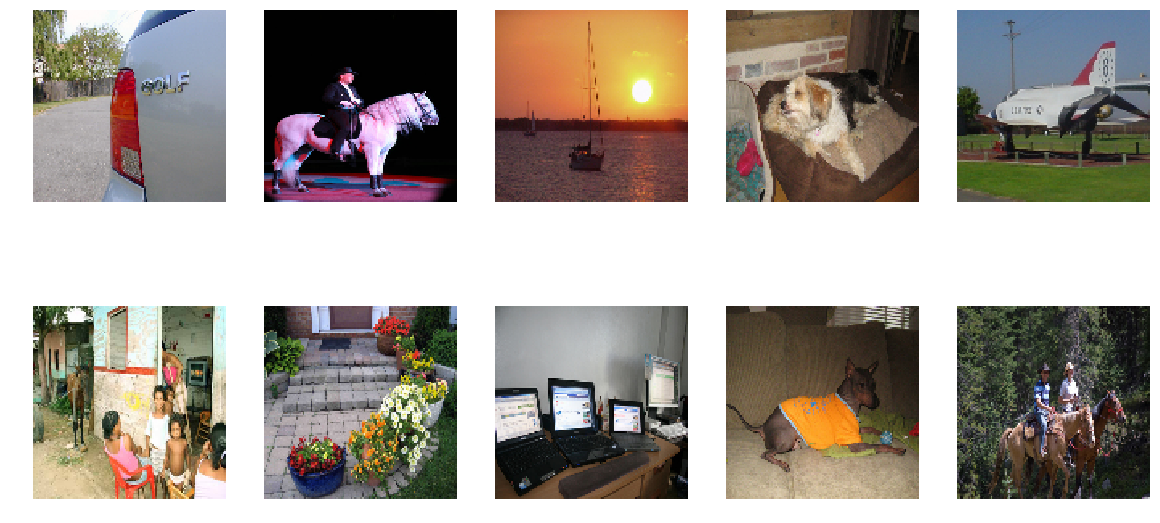

In [3]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off');

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [4]:
def get_samples(full_images, num_samples, sample_size, rand_seed=123):
    
    np.random.seed(seed=rand_seed)
    
    pic_parts = []
    
    for i in range(num_samples):
        rnd_image = np.random.randint(low=0, high=6999, size=None)
        rnd_row = np.random.randint(low=0, high=full_images[rnd_image].shape[0] - sample_size, size=None)
        rnd_col = np.random.randint(low=0, high=full_images[rnd_image].shape[0] - sample_size, size=None)
        rnd_part = full_images[rnd_image][rnd_row:(rnd_row + sample_size), rnd_col:(rnd_col + sample_size)]
        pic_parts.append(rnd_part)

    return np.asarray(pic_parts)

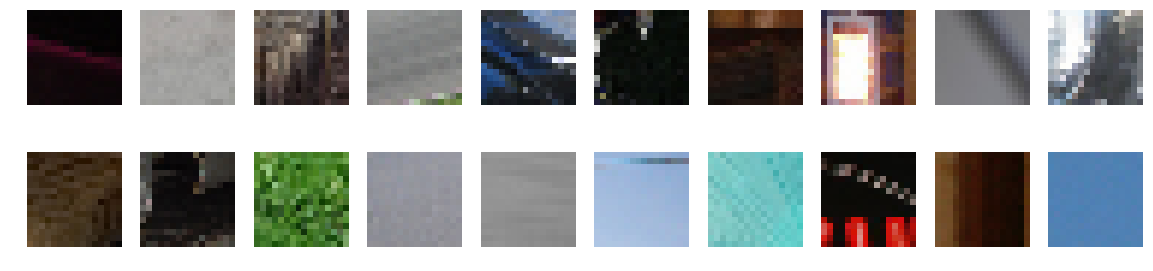

In [5]:
parts = get_samples(images, num_samples=50000, sample_size=16, rand_seed=123)

plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(4, 10, i + 1)
    plt.imshow(parts[i])
    plt.axis('off');

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.1, 0.9))

In [7]:
parts_reshaped = parts.reshape(50000, 768)

parts_scaled = scaler.fit_transform(parts_reshaped)

In [8]:
parts_scaled.shape

(50000, 768)

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [9]:
from keras.models import Input, Model
from keras.layers import Dense

Using TensorFlow backend.


In [10]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], 
                             decoder_layer_shapes=[200, 400]):
    
    inputs = Input(shape=(object_size, ))
    
    # Encoder
    encoder_1 = Dense(encoder_layer_shapes[0], activation='relu')(inputs)
    encoder_2 = Dense(encoder_layer_shapes[1], activation='relu')(encoder_1)
    encoder_3 = Dense(encoder_layer_shapes[2], activation='relu')(encoder_2)
    
    # Decoder
    input_encoded = Input(shape=(encoder_layer_shapes[2],))
    
    decoder_1 = Dense(decoder_layer_shapes[0], activation='relu')(input_encoded)
    decoder_2 = Dense(decoder_layer_shapes[1], activation='relu')(decoder_1)
    decoded = Dense(object_size, activation='sigmoid')(decoder_2)
    
    # Models
    encoder = Model(inputs, encoder_3, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
    
    return encoder, decoder, autoencoder

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [11]:
from sklearn.model_selection import train_test_split

X_scaled = np.reshape(parts_scaled, (len(parts_scaled), 768))

X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)

In [12]:
X_train.shape

(45000, 768)

In [13]:
X_test.shape

(5000, 768)

Обучите модель со стандартными параметрами.

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [14]:
encoder, decoder, autoencoder = create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], 
                             decoder_layer_shapes=[200, 400])

In [15]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               196864    
_________________________________________________________________
dense_2 (Dense)              (None, 144)               37008     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                9280      
Total params: 243,152
Trainable params: 243,152
Non-trainable params: 0
_________________________________________________________________


In [16]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               13000     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 768)               307968    
Total params: 401,368
Trainable params: 401,368
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768)               0         
_________________________________________________________________
encoder (Model)              (None, 64)                243152    
_________________________________________________________________
decoder (Model)              (None, 768)               401368    
Total params: 644,520
Trainable params: 644,520
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.compile(optimizer='adagrad', loss='mse')

In [19]:
autoencoder.fit(X_train, X_train, 
                epochs=50, batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 5s - loss: 0.0323 - val_loss: 0.0199
Epoch 2/50
45000/45000 [==============================] - 5s - loss: 0.0192 - val_loss: 0.0174
Epoch 3/50
45000/45000 [==============================] - 5s - loss: 0.0169 - val_loss: 0.0144
Epoch 4/50
45000/45000 [==============================] - 5s - loss: 0.0135 - val_loss: 0.0117
Epoch 5/50
45000/45000 [==============================] - 5s - loss: 0.0118 - val_loss: 0.0114
Epoch 6/50
45000/45000 [==============================] - 5s - loss: 0.0116 - val_loss: 0.0114
Epoch 7/50
45000/45000 [==============================] - 5s - loss: 0.0116 - val_loss: 0.0113
Epoch 8/50
45000/45000 [==============================] - 5s - loss: 0.0115 - val_loss: 0.0112
Epoch 9/50
45000/45000 [==============================] - 5s - loss: 0.0114 - val_loss: 0.0111
Epoch 10/50
45000/45000 [==============================] - 5s - loss: 0.0110 - val_loss: 0.0107


In [88]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pics(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

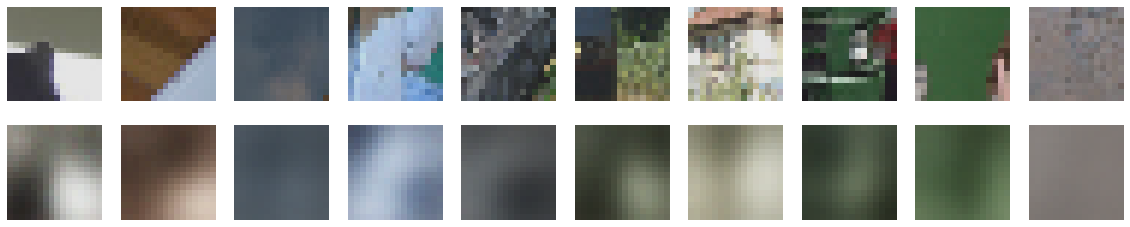

In [89]:
encoded_imgs = encoder.predict(X_train[:10], batch_size=10)
decoded_imgs = decoder.predict(encoded_imgs, batch_size=10)

shaped_decoded_imgs = decoded_imgs.reshape(len(encoded_imgs), 16, 16, 3)
shaped_X_train = X_train.reshape(len(X_train), 16, 16, 3)

plot_pics(shaped_X_train, shaped_decoded_imgs)

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

Выведем для первого скрытого слоя энкодера, остальные будут работать по аналогии:

In [66]:
from keras import backend as K

In [105]:
get_layer_output = K.function([encoder.layers[0].input],
                                  [encoder.layers[1].output])

In [116]:
layer1_output = get_layer_output([X_train])[0]

In [117]:
get_layer_output([X_train])[0].shape

(45000, 256)

Номера изображений которые дают максимальную активацию на каждом из 256 нейронов слоя:

In [133]:
np.argmax(layer1_output, axis=0)

array([    0,     0,     0,     0,     0,  5527, 14156,     0, 32808,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,  9154,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 23682,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 17231,     0, 43319,     0,     0,
           0,     0,     0, 21325,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 28802,
         359,     0,     0,     0,  5613,     0,     0,     0,     0,
           0, 31601,     0,  6885,     0, 20903,  2867,     0,     0,
       18192,     0,     0, 19662,     0,     0,     0, 36190,     0,
           0,     0,     0,     0,     0, 13268,  8916,     0,     0,
       28578,     0,     0,     0,     0,     0,     0,     0,     0,
           0, 25901,     0, 35241, 43998,     0,     0,     0, 19628,
           0,     0, 29743,     0,     0,     0,     0, 11449,     0,
       21279,     0,

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

Уменьшим количество нейронов в 2 раза:

In [22]:
encoder2, decoder2, autoencoder2 = create_autoencoder_model(object_size=768, encoder_layer_shapes=[128, 72, 32], 
                             decoder_layer_shapes=[100, 200])

autoencoder2.compile(optimizer='adagrad', loss='mse')

autoencoder2.fit(X_train, X_train, 
                epochs=50, batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 3s - loss: 0.0294 - val_loss: 0.0179
Epoch 2/50
45000/45000 [==============================] - 2s - loss: 0.0162 - val_loss: 0.0143
Epoch 3/50
45000/45000 [==============================] - 2s - loss: 0.0144 - val_loss: 0.0142
Epoch 4/50
45000/45000 [==============================] - 2s - loss: 0.0140 - val_loss: 0.0124
Epoch 5/50
45000/45000 [==============================] - 3s - loss: 0.0124 - val_loss: 0.0116
Epoch 6/50
45000/45000 [==============================] - 2s - loss: 0.0117 - val_loss: 0.0113
Epoch 7/50
45000/45000 [==============================] - 2s - loss: 0.0115 - val_loss: 0.0111
Epoch 8/50
45000/45000 [==============================] - 2s - loss: 0.0113 - val_loss: 0.0108
Epoch 9/50
45000/45000 [==============================] - 2s - loss: 0.0109 - val_loss: 0.0109
Epoch 10/50
45000/45000 [==============================] - 3s - loss: 0.0108 - val_loss: 0.0106


Лосс выше, чем когда нейронов было больше. Обучилась модель быстрее.

Оставим боттлнек и по одному скрытому слою для энкодера и декодера:

In [26]:
def create_truncated_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 64], 
                             decoder_layer_shapes=[400]):
    
    inputs = Input(shape=(object_size, ))
    
    # Encoder
    encoder_1 = Dense(encoder_layer_shapes[0], activation='relu')(inputs)
    encoder_2 = Dense(encoder_layer_shapes[1], activation='relu')(encoder_1)
    
    # Decoder
    input_encoded = Input(shape=(encoder_layer_shapes[1],))
    
    decoder_1 = Dense(decoder_layer_shapes[0], activation='relu')(input_encoded)
    decoded = Dense(object_size, activation='sigmoid')(decoder_1)
    
    # Models
    encoder = Model(inputs, encoder_2, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
    
    return encoder, decoder, autoencoder

In [27]:
encoder3, decoder3, autoencoder3 = create_truncated_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 64], 
                             decoder_layer_shapes=[400])

autoencoder3.compile(optimizer='adagrad', loss='mse')

autoencoder3.fit(X_train, X_train, 
                epochs=50, batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 4s - loss: 0.0473 - val_loss: 0.0453
Epoch 2/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0453
Epoch 3/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0454
Epoch 4/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0453
Epoch 5/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0453
Epoch 6/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0454
Epoch 7/50
45000/45000 [==============================] - 5s - loss: 0.0470 - val_loss: 0.0453
Epoch 8/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0453
Epoch 9/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0453
Epoch 10/50
45000/45000 [==============================] - 4s - loss: 0.0470 - val_loss: 0.0454


Лосс стал еще выше. Первая модель давала наилучший результат. Можно было бы еще больше моделей обучить, но комп не вывозит.

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [28]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [29]:
x_test.shape, x_train.shape

((10000, 28, 28), (60000, 28, 28))

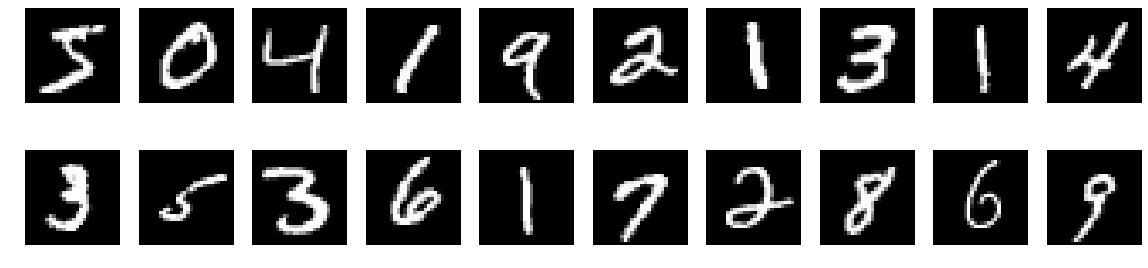

In [30]:
plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(4, 10, i + 1)
    plt.imshow(x_train[i])
    plt.axis('off');

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [31]:
x_train = np.reshape(x_train, (len(x_train), 28*28))
x_test  = np.reshape(x_test,  (len(x_test),  28*28))
x_train = scaler.fit_transform(x_train)
x_test  = scaler.fit_transform(x_test)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
from keras.models import Input, Model
from keras.layers import Dense

In [33]:
def create_dense_ae(object_size, colour):
    # Размерность кодированного представления
    encoding_dim = 30

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(object_size * object_size * colour,))

    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    decoded = Dense(object_size*object_size*colour, activation='sigmoid')(input_encoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [34]:
encoder, decoder, autoencoder = create_dense_ae(object_size=28, colour=1)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [35]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 30)                23550     
Total params: 23,550
Trainable params: 23,550
Non-trainable params: 0
_________________________________________________________________


In [36]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 784)               24304     
Total params: 24,304
Trainable params: 24,304
Non-trainable params: 0
_________________________________________________________________


In [37]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 30)                23550     
_________________________________________________________________
decoder (Model)              (None, 784)               24304     
Total params: 47,854
Trainable params: 47,854
Non-trainable params: 0
_________________________________________________________________


In [38]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 0.4592 - val_loss: 0.4174
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.4096 - val_loss: 0.4015
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 0.3976 - val_loss: 0.3929
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 0.3910 - val_loss: 0.3878
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 0.3872 - val_loss: 0.3853
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 0.3856 - val_loss: 0.3844
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.3850 - val_loss: 0.3839
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 0.3847 - val_loss: 0.3837
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 0.3845 - val_loss: 0.3836
Epoch 10/50
60000/60000 [==============================] - 2s - loss: 0.3844 - val_loss: 0.3835

Посмотрим на восстановленные изображения:

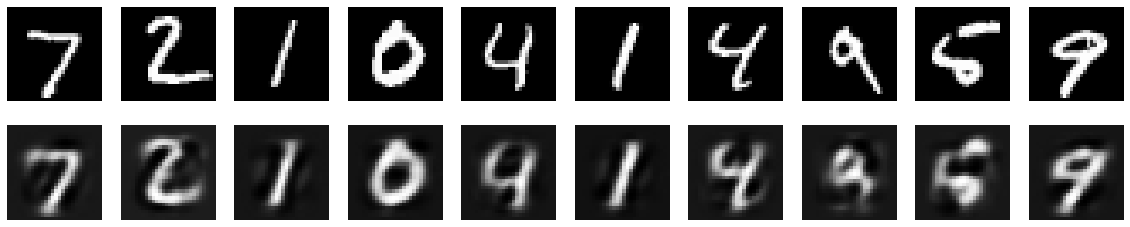

In [41]:
encoded_imgs = encoder.predict(x_test[:10])
decoded_imgs = decoder.predict(encoded_imgs)

shaped_decoded_imgs = decoded_imgs.reshape(len(decoded_imgs), 28, 28)
shaped_x_test = x_test.reshape(len(x_test), 28, 28)

plot_pics(shaped_x_test[:10], shaped_decoded_imgs[:10])

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

In [40]:
encoded_x_test = encoder.predict(x_test)
encoded_x_train = encoder.predict(x_train)

In [41]:
encoded_x_test.shape, encoded_x_train.shape

((10000, 30), (60000, 30))

In [42]:
y_test.shape, y_train.shape

((10000,), (60000,))

In [64]:
from sklearn.metrics import accuracy_score

KNN:

In [43]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(encoded_x_train, y_train)

accuracy_score(y_test, KNN.predict(encoded_x_test))

0.97240000000000004

SVM:

In [44]:
from sklearn.svm import SVC

SVC = SVC()
SVC.fit(encoded_x_train, y_train)

accuracy_score(y_test, SVC.predict(encoded_x_test))

0.98229999999999995

RandomForest:

In [45]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(encoded_x_train, y_train)

accuracy_score(y_test, RFC.predict(encoded_x_test))

0.9244

GBClassifier:

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
GBC.fit(encoded_x_train, y_train)

accuracy_score(y_test, GBC.predict(encoded_x_test))

0.92749999999999999

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [1]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [2]:
y_train[0]

array([6], dtype=uint8)

In [43]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

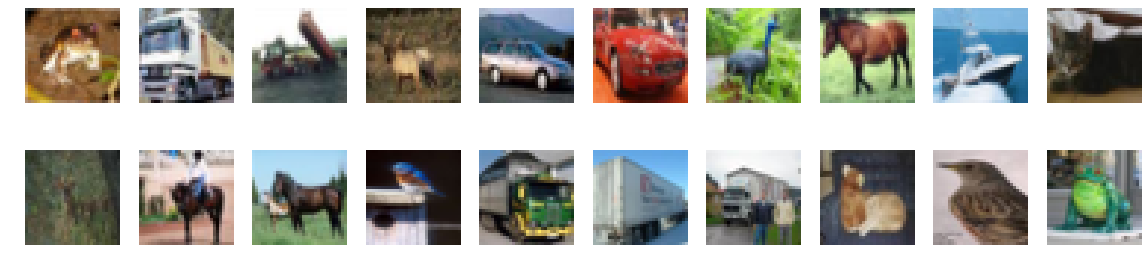

In [44]:
plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(4, 10, i + 1)
    plt.imshow(x_train[i])
    plt.axis('off');

Создаем случайные сэмплы:

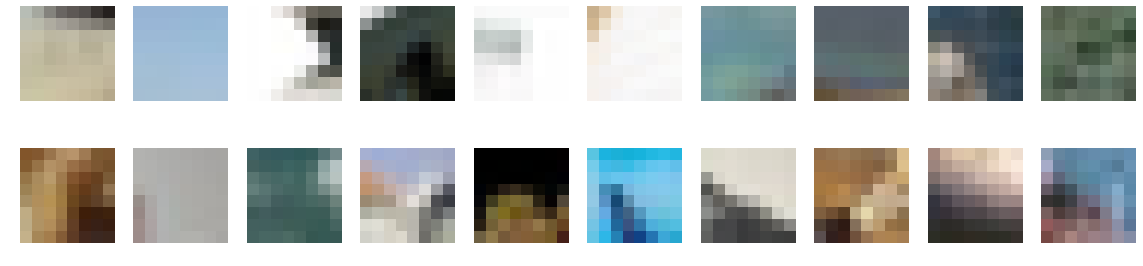

In [45]:
parts = get_samples(x_train, num_samples=50000, sample_size=8, rand_seed=123)

plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(4, 10, i + 1)
    plt.imshow(parts[i])
    plt.axis('off');

In [46]:
parts_reshaped = parts.reshape(50000, 8*8*3)

parts_scaled = scaler.fit_transform(parts_reshaped)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
X_scaled = np.reshape(parts_scaled, (len(parts_scaled), 8*8*3))

X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)

In [48]:
X_train.shape, X_test.shape

((45000, 192), (5000, 192))

In [49]:
encoder, decoder, autoencoder = create_dense_ae(object_size=8, colour=3)
autoencoder.compile(optimizer='adagrad', loss='mse')

In [50]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 192)               0         
_________________________________________________________________
encoder (Model)              (None, 30)                5790      
_________________________________________________________________
decoder (Model)              (None, 192)               5952      
Total params: 11,742
Trainable params: 11,742
Non-trainable params: 0
_________________________________________________________________


In [51]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 0s - loss: 0.0258 - val_loss: 0.0186
Epoch 2/50
45000/45000 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0133
Epoch 3/50
45000/45000 [==============================] - 0s - loss: 0.0115 - val_loss: 0.0106
Epoch 4/50
45000/45000 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0082
Epoch 5/50
45000/45000 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0071
Epoch 6/50
45000/45000 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0063
Epoch 7/50
45000/45000 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0058
Epoch 8/50
45000/45000 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0054
Epoch 9/50
45000/45000 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0051
Epoch 10/50
45000/45000 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0049


Посмотрим, как сработал автоэнкодер:

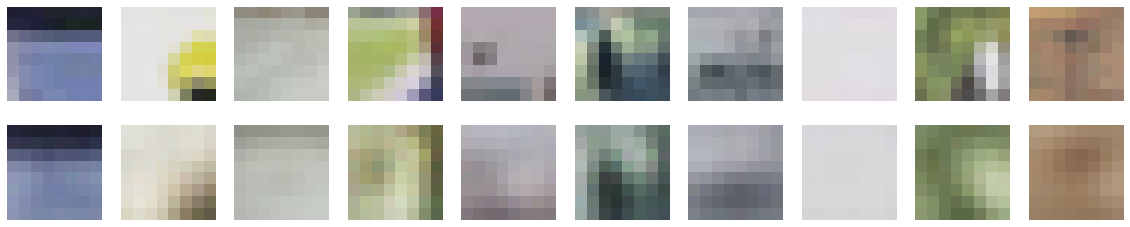

In [52]:
encoded_imgs = encoder.predict(X_test[:10])
decoded_imgs = decoder.predict(encoded_imgs)

shaped_decoded_imgs = decoded_imgs.reshape(len(decoded_imgs), 8, 8, 3)
shaped_x_test = X_test.reshape(len(X_test), 8, 8, 3)

plot_pics(shaped_x_test, shaped_decoded_imgs)

Теперь разделите каждую картинку из датасета на 16 сэмплjd размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

In [53]:
def divide_pic(pic_array, num_samples, sample_size):
    pic_parts = []
    for pic in pic_array:
        for i in range(num_samples):
            rnd_row = np.random.randint(low=0, high=pic.shape[0] - sample_size, size=None)
            rnd_col = np.random.randint(low=0, high=pic.shape[1] - sample_size, size=None)
            rnd_part = pic[rnd_row:(rnd_row + sample_size), rnd_col:(rnd_col + sample_size)]
            pic_parts.append(rnd_part)
    return np.asarray(pic_parts)    

In [54]:
x_train_divided = divide_pic(pic_array=x_train, num_samples=16, sample_size=8)
x_test_divided = divide_pic(pic_array=x_test, num_samples=16, sample_size=8)

x_train_divided = x_train_divided.reshape(len(x_train_divided), -1)
x_test_divided = x_test_divided.reshape(len(x_test_divided), -1)

In [55]:
x_train_divided.shape, x_test_divided.shape

((800000, 192), (160000, 192))

In [56]:
encoded_x_train_divided = encoder.predict(x_train_divided)
encoded_x_test_divided = encoder.predict(x_test_divided)

In [57]:
encoded_x_train_divided.shape, encoded_x_test_divided.shape

((800000, 30), (160000, 30))

In [58]:
encoded_x_train = encoded_x_train_divided.reshape(int(len(encoded_x_train_divided)/16), 480)
encoded_x_test = encoded_x_test_divided.reshape(int(len(encoded_x_test_divided)/16), 480)

In [59]:
encoded_x_train.shape, encoded_x_test.shape

((50000, 480), (10000, 480))

Теперь обучите SVM на преобразованных объектах и выведите точность.

In [60]:
from sklearn.svm import SVC

In [61]:
SVC = SVC()

SVC.fit(encoded_x_train[:20000], y_train[:20000])

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
y_hat = SVC.predict(encoded_x_test[:2000])

In [65]:
accuracy_score(y_test[:2000], y_hat)

0.097500000000000003

Что-то все довольно плохо, но большую выборку мой комп не вывозит.